## Loading Dataset


In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

In [9]:


# Load preprocessed dataset
data = pd.read_csv('housing_price_dataset.csv')

# Downsample the dataset to 2,000 samples
data_subset = data.sample(n=2000, random_state=42)

# Features and target
features = ['SquareFeet', 'Bedrooms', 'Bathrooms', 'Neighborhood_Category', 'YearBuilt']
target = 'Price'

X = data_subset[features]
y = data_subset[target]


# Splitting the dataset
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)

# Display the shapes of each set
print("Train set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)


Train set shape: (1400, 5) (1400,)
Validation set shape: (300, 5) (300,)
Test set shape: (300, 5) (300,)


## Neural Networks

In [10]:
import numpy as np
import matplotlib.pyplot as plt


# Neural Network architecture parameters
input_size = X_train.shape[1]
hidden_size = 5    
# neurons
output_size = 1


# Normalize y_train and y_val
y_mean = np.mean(y_train)
y_std = np.std(y_train)
y_train = (y_train - y_mean) / y_std
y_val = (y_val - y_mean) / y_std

# Normalize y_test
y_test = (y_test - y_mean) / y_std




In [11]:
# Initialize weights with two different methods
def initialize_weights(method, input_size, hidden_size, output_size):
    if method == 'zeros':
        W1 = np.zeros((input_size, hidden_size))
        b1 = np.zeros((1, hidden_size))
        W2 = np.zeros((hidden_size, output_size))
        b2 = np.zeros((1, output_size))
    elif method == 'random':
        W1 = np.random.randn(input_size, hidden_size) * 0.5
        b1 = np.zeros((1, hidden_size))
        W2 = np.random.randn(hidden_size, output_size) * 0.5
        b2 = np.zeros((1, output_size))
    else:
        raise ValueError("Invalid initialization method")
    return {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

# Activation functions and their derivatives
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

# Forward propagation
def forward_propagation(X, params):
    W1, b1, W2, b2 = params['W1'], params['b1'], params['W2'], params['b2']
    
    # Hidden layer
    Z1 = np.dot(X, W1) + b1
    A1 = relu(Z1)
    
    # Output layer
    Z2 = np.dot(A1, W2) + b2
    y_pred = Z2
    
    return {'Z1': Z1, 'A1': A1, 'Z2': Z2, 'y_pred': y_pred}

# Backward propagation
def backward_propagation(X, y, params, cache):
    m = X.shape[0]
    W1, b1, W2, b2 = params['W1'], params['b1'], params['W2'], params['b2']
    Z1, A1, Z2, y_pred = cache['Z1'], cache['A1'], cache['Z2'], cache['y_pred']
    
    # Calculate derivatives
    dZ2 = y_pred - y  # Shape should be (batch_size, output_size)
    dW2 = (1 / m) * np.dot(A1.T, dZ2)  # Shapes: (hidden_size, batch_size) * (batch_size, output_size) = (hidden_size, output_size)
    db2 = (1 / m) * np.sum(dZ2, axis=0, keepdims=True)  # Shape should be (1, output_size)
    dZ1 = np.dot(dZ2, W2.T) * relu_derivative(Z1)  # Shapes: (batch_size, output_size) * (output_size, hidden_size) = (batch_size, hidden_size)
    dW1 = (1 / m) * np.dot(X.T, dZ1)  # Shapes: (features, batch_size) * (batch_size, hidden_size) = (features, hidden_size)
    db1 = (1 / m) * np.sum(dZ1, axis=0, keepdims=True)  # Shape should be (1, hidden_size)
    
    # Update parameters
    params['W2'] -= 0.01 * dW2
    params['b2'] -= 0.01 * db2
    params['W1'] -= 0.01 * dW1
    params['b1'] -= 0.01 * db1
    
    return params



# Training function
def train(X, y, X_val, y_val, method, num_iterations=1000, patience=10):
    params = initialize_weights(method, input_size, hidden_size, output_size)
    losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_params = params.copy()
    counter = 0
    
    for epoch in range(num_iterations):
        cache = forward_propagation(X, params)
        y_pred = cache['y_pred']
        
        # Calculate training loss (MSE)
        loss = np.mean(np.square(y_pred - y))
        losses.append(loss)
        
        # Calculate validation loss (MSE)
        val_cache = forward_propagation(X_val, params)
        val_y_pred = val_cache['y_pred']
        val_loss = np.mean(np.square(val_y_pred - y_val))
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch}: Training Loss: {loss}, Validation Loss: {val_loss}")
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = params.copy()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping at epoch", epoch)
                break
        
        # Backpropagation and parameter updates
        params = backward_propagation(X, y, params, cache)
        
    return best_params, losses, val_losses







In [12]:
# Train using zero initialization
print("\nTraining using Zero Weights Initialization Losses\n")
params_zeros, losses_zeros, val_losses_zeros = train(
    X_train, y_train.to_numpy().reshape(-1, 1),
    X_val, y_val.to_numpy().reshape(-1, 1),
    method='zeros'
)

# Train using random initialization
print("Training using Random Weights Initialization Losses")
params_random, losses_random, val_losses_random = train(
    X_train, y_train.to_numpy().reshape(-1, 1),
    X_val, y_val.to_numpy().reshape(-1, 1),
    method='random'
)




Training using Zero Weights Initialization Losses

Epoch 0: Training Loss: 0.999999999999999, Validation Loss: 0.9293867227693068
Epoch 1: Training Loss: 0.999999999999999, Validation Loss: 0.9293867227693068
Epoch 2: Training Loss: 0.999999999999999, Validation Loss: 0.9293867227693068
Epoch 3: Training Loss: 0.999999999999999, Validation Loss: 0.9293867227693068
Epoch 4: Training Loss: 0.999999999999999, Validation Loss: 0.9293867227693068
Epoch 5: Training Loss: 0.999999999999999, Validation Loss: 0.9293867227693068
Epoch 6: Training Loss: 0.999999999999999, Validation Loss: 0.9293867227693068
Epoch 7: Training Loss: 0.999999999999999, Validation Loss: 0.9293867227693068
Epoch 8: Training Loss: 0.999999999999999, Validation Loss: 0.9293867227693068
Epoch 9: Training Loss: 0.999999999999999, Validation Loss: 0.9293867227693068
Epoch 10: Training Loss: 0.999999999999999, Validation Loss: 0.9293867227693068
Early stopping at epoch 10
Training using Random Weights Initialization Losses

Epoch 107: Training Loss: 0.9631555898031872, Validation Loss: 0.88286639308268
Epoch 108: Training Loss: 0.9628922793223027, Validation Loss: 0.8826304752735056
Epoch 109: Training Loss: 0.9626289886804258, Validation Loss: 0.8823942457772034
Epoch 110: Training Loss: 0.9623659886714399, Validation Loss: 0.8821580111434251
Epoch 111: Training Loss: 0.9621026661103066, Validation Loss: 0.8819214572599211
Epoch 112: Training Loss: 0.9618390611634602, Validation Loss: 0.8816845819187048
Epoch 113: Training Loss: 0.9615751919562742, Validation Loss: 0.8814487551252309
Epoch 114: Training Loss: 0.9613109602996522, Validation Loss: 0.881213318003538
Epoch 115: Training Loss: 0.9610463956581968, Validation Loss: 0.880977545011702
Epoch 116: Training Loss: 0.9607814976409814, Validation Loss: 0.880741428685893
Epoch 117: Training Loss: 0.9605162613520125, Validation Loss: 0.8805049201097727
Epoch 118: Training Loss: 0.9602509235341686, Validation Loss: 0.8802680688504471
Epoch 119: Training L

Epoch 297: Training Loss: 0.9059830918223315, Validation Loss: 0.8316544480516819
Epoch 298: Training Loss: 0.9056280316321301, Validation Loss: 0.8313307966376273
Epoch 299: Training Loss: 0.9052722049758147, Validation Loss: 0.8310064129179944
Epoch 300: Training Loss: 0.9049158102147488, Validation Loss: 0.8306816378428907
Epoch 301: Training Loss: 0.9045586726073941, Validation Loss: 0.8303561991143376
Epoch 302: Training Loss: 0.9042008784135399, Validation Loss: 0.8300300979380347
Epoch 303: Training Loss: 0.9038423856906487, Validation Loss: 0.8297032081539806
Epoch 304: Training Loss: 0.9034831708332811, Validation Loss: 0.8293754850649265
Epoch 305: Training Loss: 0.9031231699817129, Validation Loss: 0.8290472861762994
Epoch 306: Training Loss: 0.9027625327248107, Validation Loss: 0.8287184928747379
Epoch 307: Training Loss: 0.9024011342367793, Validation Loss: 0.8283889974351418
Epoch 308: Training Loss: 0.9020389626239355, Validation Loss: 0.82805879876482
Epoch 309: Trainin

Epoch 495: Training Loss: 0.820502331891326, Validation Loss: 0.7534042009831554
Epoch 496: Training Loss: 0.819991563937721, Validation Loss: 0.7529358303101289
Epoch 497: Training Loss: 0.8194798845653541, Validation Loss: 0.7524667750627116
Epoch 498: Training Loss: 0.8189671383757066, Validation Loss: 0.751996743276473
Epoch 499: Training Loss: 0.8184537845017589, Validation Loss: 0.7515258946027873
Epoch 500: Training Loss: 0.8179403630205534, Validation Loss: 0.7510546275418866
Epoch 501: Training Loss: 0.8174262455164952, Validation Loss: 0.7505826973298173
Epoch 502: Training Loss: 0.8169113560295435, Validation Loss: 0.7501100852378105
Epoch 503: Training Loss: 0.8163957083677781, Validation Loss: 0.7496368006274821
Epoch 504: Training Loss: 0.815879303787826, Validation Loss: 0.7491628447718852
Epoch 505: Training Loss: 0.8153621450935207, Validation Loss: 0.7486882189619968
Epoch 506: Training Loss: 0.8148442475523582, Validation Loss: 0.7482129398244042
Epoch 507: Training 

Epoch 688: Training Loss: 0.7103437153561493, Validation Loss: 0.6524496293822019
Epoch 689: Training Loss: 0.7097296370057015, Validation Loss: 0.6518888411473406
Epoch 690: Training Loss: 0.7091154557062919, Validation Loss: 0.6513281614028684
Epoch 691: Training Loss: 0.708501478057931, Validation Loss: 0.6507671968382485
Epoch 692: Training Loss: 0.7078880981044126, Validation Loss: 0.6502066554998215
Epoch 693: Training Loss: 0.7072735662863673, Validation Loss: 0.6496454299058583
Epoch 694: Training Loss: 0.7066591631341524, Validation Loss: 0.6490844259945531
Epoch 695: Training Loss: 0.7060445688037412, Validation Loss: 0.6485233838352074
Epoch 696: Training Loss: 0.7054299652345944, Validation Loss: 0.6479624323195975
Epoch 697: Training Loss: 0.7048145702232242, Validation Loss: 0.6474011071177465
Epoch 698: Training Loss: 0.704199197559385, Validation Loss: 0.6468398943451762
Epoch 699: Training Loss: 0.7035838346330987, Validation Loss: 0.6462787860692516
Epoch 700: Trainin

Epoch 882: Training Loss: 0.5971455980810272, Validation Loss: 0.5501773029849744
Epoch 883: Training Loss: 0.596624653396734, Validation Loss: 0.5497087059924212
Epoch 884: Training Loss: 0.5961040926730325, Validation Loss: 0.5492411763736533
Epoch 885: Training Loss: 0.5955831937027679, Validation Loss: 0.5487736375275358
Epoch 886: Training Loss: 0.5950621525261582, Validation Loss: 0.5483062119461274
Epoch 887: Training Loss: 0.5945419009465628, Validation Loss: 0.547835253651586
Epoch 888: Training Loss: 0.5940222549174735, Validation Loss: 0.5473638716953282
Epoch 889: Training Loss: 0.5935032040530847, Validation Loss: 0.546893250849946
Epoch 890: Training Loss: 0.5929851918407328, Validation Loss: 0.5464234410993322
Epoch 891: Training Loss: 0.5924687443414457, Validation Loss: 0.5459546624175287
Epoch 892: Training Loss: 0.5919540989418721, Validation Loss: 0.5454880208884532
Epoch 893: Training Loss: 0.5914404022306178, Validation Loss: 0.5450231431977238
Epoch 894: Training

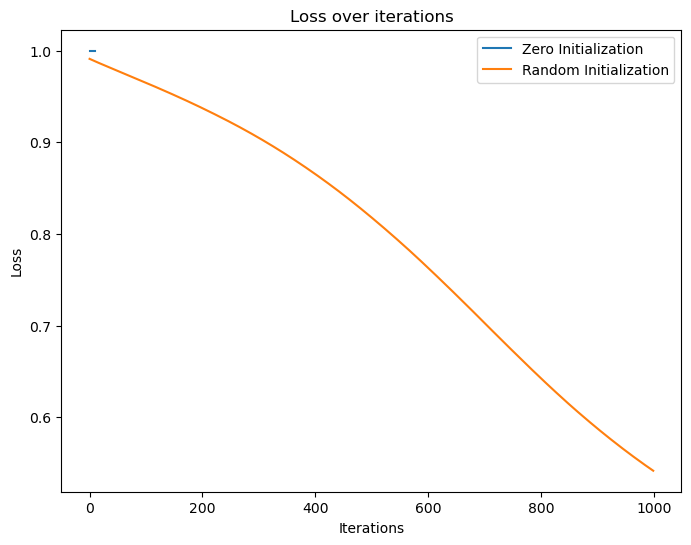

In [13]:
# Plotting the loss
plt.figure(figsize=(8, 6))
plt.plot(losses_zeros, label='Zero Initialization')
plt.plot(losses_random, label='Random Initialization')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss over iterations')
plt.legend()
plt.show()


Random Initialization performs better than Zeros Initialization

Training using Zero Weights Initialization Losses: Early stopping at epoch 10 

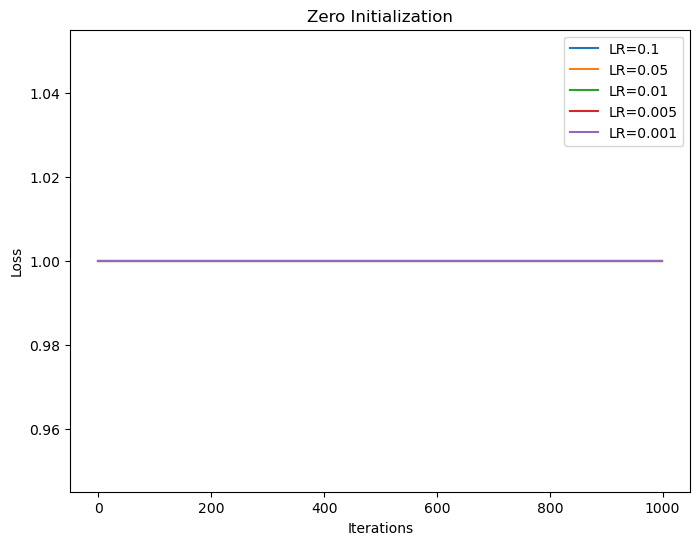

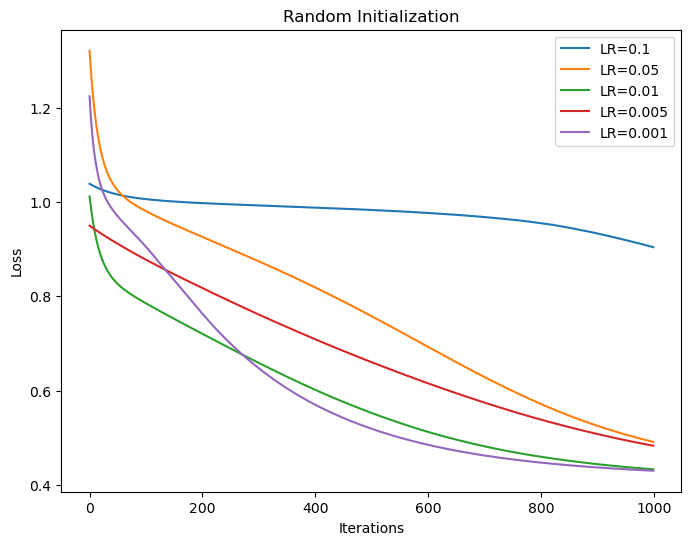

In [22]:
# Training function with variable learning rates
def train_with_lr(X, y, method='zeros', learning_rate=0.01, num_iterations=1000):
    params = initialize_weights(method, input_size, hidden_size, output_size)
    losses = []
    
    for i in range(num_iterations):
        cache = forward_propagation(X, params)
        y_pred = cache['y_pred']
        
        # Calculate loss (MSE)
        loss = np.mean(np.square(y_pred - y))
        losses.append(loss)
        
        # Backpropagation and parameter updates
        params = backward_propagation(X, y, params, cache)
        
    return params, losses

learning_rates = [0.1, 0.05, 0.01, 0.005, 0.001]
methods = ['zeros', 'random']

# Plotting for Zero Initialization with different learning rates
plt.figure(figsize=(8, 6))
plt.title('Zero Initialization')
for lr in learning_rates:
    _, losses = train_with_lr(X_train, y_train.to_numpy().reshape(-1, 1), method='zeros', learning_rate=lr)
    label = f'LR={lr}'
    plt.plot(losses, label=label)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting for Random Initialization with different learning rates
plt.figure(figsize=(8, 6))
plt.title('Random Initialization')
for lr in learning_rates:
    _, losses = train_with_lr(X_train,y_train.to_numpy().reshape(-1, 1), method='random', learning_rate=lr)
    label = f'LR={lr}'
    plt.plot(losses, label=label)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()


0.001 gives better results for Random Initialization

In [15]:
from sklearn.metrics import mean_squared_error, r2_score

# Function to calculate and print evaluation metrics
def evaluate_model(X, y, params, name):
    cache = forward_propagation(X, params)
    y_pred = cache['y_pred']
    
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    print(f"{name} model evaluation:")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R-squared (R2): {r2}")
    print("------------")

# Evaluate zero initialization model
evaluate_model(X_train, y_train.to_numpy().reshape(-1, 1), params_zeros, "Zero Initialization (Training)")
evaluate_model(X_test, y_test.to_numpy().reshape(-1, 1), params_zeros, "Zero Initialization (Testing)")

# Evaluate random initialization model
evaluate_model(X_train, y_train.to_numpy().reshape(-1, 1), params_random, "Random Initialization (Training)")
evaluate_model(X_test, y_test.to_numpy().reshape(-1, 1), params_random, "Random Initialization (Testing)")


Zero Initialization (Training) model evaluation:
Mean Squared Error (MSE): 0.999999999999999
R-squared (R2): 0.0
------------
Zero Initialization (Testing) model evaluation:
Mean Squared Error (MSE): 0.9761379692244183
R-squared (R2): -0.011731377219113215
------------
Random Initialization (Training) model evaluation:
Mean Squared Error (MSE): 0.5413246885528186
R-squared (R2): 0.4586753114471809
------------
Random Initialization (Testing) model evaluation:
Mean Squared Error (MSE): 0.5089341540884552
R-squared (R2): 0.47250832478233584
------------


The evaluation results suggest that the models perform quite differently on the testing data compared to the training data. 

For the zero initialization model, both the training and testing results indicate poor performance, as indicated by a close-to-1 MSE and near-zero R-squared values. This suggests that the model is not capturing the variance present in the data and is performing poorly on unseen examples.

On the other hand, the random initialization model performs relatively better on both training and testing datasets, with lower MSE values closer to 0 and higher R-squared values around 0.5. It suggests that this model captures some patterns and performs better on unseen data compared to the zero initialization model.
